# Exploratory Data Analysis

## New York Time Articles - Sentiment Analysis

### Goal of this notebook

> Extract sentiment from text and look for trends amongst articles and for the NYT as an organization.

### Sentiment Analysis

Import libraries.

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from textblob import TextBlob
import matplotlib.pyplot as plt
from src.paths import LOCAL_INTERIM_DATA_PATH
from src.visualization.Plotter import show_wordcloud
from src.processing.IOController import load_normalized_nyt_df
from src.processing.DataFrameManipulator import breakdown_cat_distribution
tqdm.pandas()
pd.options.display.max_colwidth=300

Load dataset.

In [419]:
df = load_normalized_nyt_df(LOCAL_INTERIM_DATA_PATH / 'nyt-articles-consolidated.csv')

Extract sentiment.

> Ideally a sentiment analysis should be done with a trained classifier with the same context as the dataset to predict. But again for simplicities purpouses we're taking a shortcut with a well known Python library, TextBlob. It has a pre-trained model which can be used for preliminary analysis. Let's first extract sentiment and store it into two usefull columns, `sentiment.polarity` (positive/negative) and `subjectivity` (objective/subjective).

In [311]:
df['abstract_sentiment'] = df.abstract.astype(str).progress_apply(lambda x: TextBlob(x).sentiment)
df['sentiment.polarity'] = df['abstract_sentiment'].apply(lambda x: x[0])
df['sentiment.subjectivity'] = df['abstract_sentiment'].apply(lambda x: x[1])

Check sentiment polarity distribution.

> I would expect more neutral sentiment on a newspapers, but here we can see that that the average gravitates a little bit over neutral with 0.06 and standard deviation of 0.21. Looking at the boxplot below there's a more intuitive approach of the analysis.

In [434]:
df['sentiment.polarity'].describe()

count    21116.000000
mean         0.061884
std          0.214532
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.166667
max          1.000000
Name: sentiment.polarity, dtype: float64

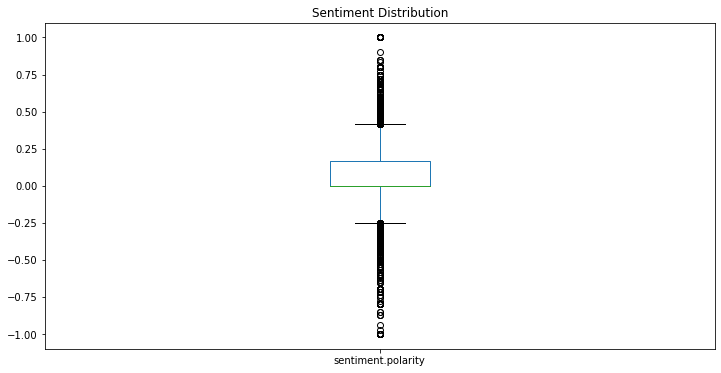

In [436]:
df['sentiment.polarity'].plot(kind='box', figsize=(12,6), title='Sentiment Distribution')

Check top and bottom 5 articles whe it comes to sentiment polarity.

> Apparently the model seems to be capturing indeed some sentiment, Sports look to shine with good mood where Foreing and Business matters are darker... Let's see quantitatively if that is true.

In [443]:
df.sort_values('sentiment.polarity')[['abstract', 'sentiment.polarity', 'news_desk']]

,abstract,sentiment.polarity,news_desk
2975,"The country’s warring parties have proposed ways to end a devastating war, but yawning gaps remain and making progress will be tricky.",-1.0,Foreign
19222,African-Americans and Latinos are especially vulnerable to job losses in the pandemic and at a disadvantage in getting government support.,-1.0,Business
19770,"Tokyo may have been lulled into complacency during the weeks when Japan contained the coronavirus while avoiding economically devastating lockdowns, our bureau chief writes.",-1.0,Foreign
5121,The pandemic is devastating start-ups. This matters in ways we can’t always see.,-1.0,Business
861,Ekrem Imamoglu shockingly won the city’s mayoralty in part by wooing the lower and middle-income voters who had powered President Erdogan’s rise.,-1.0,Foreign
...,...,...,...
877,"The United States midfielder sees her outspoken nature as an obligation, and the World Cup as the perfect stage from which to speak her mind.",1.0,Sports
16721,"Darren Eales built Atlanta United into an M.L.S. champion. Now, after losing his coach and selling his best player, he has to try to do it all over again.",1.0,Sports
3037,China’s women’s national team was once one of the world’s best. Now it hopes to regain its glory as part of Xi Jinping’s effort to make China a soccer superpower.,1.0,Sports
16529,"The Pelicans guard was drafted by the Lakers, but he is playing his best basketball now, six months after they traded him.",1.0,Sports


Plot the sentiment across news desks.

> Here we have to watch out for the new_desks with very small count, since it may not attend statistical representativity with an acceptable error. As a good rule of thump, it's better to cross out cases where sample size is lower than 300 (minimal sample size for 95% confidence interval and 5% margin of error for any sample).

In [465]:
tmp = df.groupby(['news_desk'])['sentiment.polarity'].agg(['mean', 'count']).sort_values('mean', ascending=False)
tmp

,mean,count
news_desk,,
Health,0.208333,4
Arts,0.200413,50
Technology,0.101247,11
Politics,0.090786,2570
U.S.,0.086411,1006
Sports,0.081340,3631
Movies,0.079853,12
World,0.078949,96
Science,0.076433,1758


Check it visually.

> Interestingly Politics have a higher sentiment than sports... Apparently americans are in fact very patriotic since U.S. is on 2nd rank. Nevertheless we should be cautious before assuming any premisse with this preliminary results, since the TextBlob model was not trained for this specific linguistic domain. 

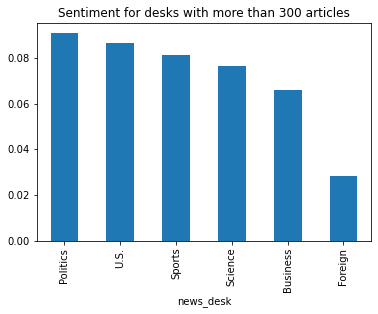

In [472]:
tmp[tmp['count']>300]['mean'].plot(kind='bar', title='Sentiment for desks with more than 300 articles')

Explode DataFrame based on `keywords` column.

> Let's use the features inside `keywords`, there we can find many persons , organization and even subjects for structuring our data.

In [313]:
exploded_df = df.explode('keywords')
exploded_df['keywords.name'] = exploded_df.keywords.apply(lambda x: x['name'] if isinstance(x, dict) else 'others')
exploded_df['keywords.value'] = exploded_df.keywords.apply(lambda x: x['value'] if isinstance(x, dict) else 'others')

Check Biden vs. Trump.

> The sentiment for Trump vs. Biden doe show a tendency for more positive inclination to the Democratic Party. Does it ring any bells to say NYT is a little bit "leftish" ? :) By the way, sample sizes are okay here (over 300)!

In [395]:
mask = exploded_df['keywords.value'].isin(['Trump, Donald J', 'Biden, Joseph R Jr'])
pd.concat([exploded_df[mask]['keywords.value'].value_counts().rename('count'),
exploded_df[mask].groupby(['keywords.value'])['sentiment.polarity'].mean().sort_values(ascending=False)], axis=1)

,count,sentiment.polarity
"Trump, Donald J",1919,0.053770
"Biden, Joseph R Jr",962,0.095209


Check sentiment over time.

> We can see a consistent trend for more positive articles when refering to Biden as in comparison to Trump.

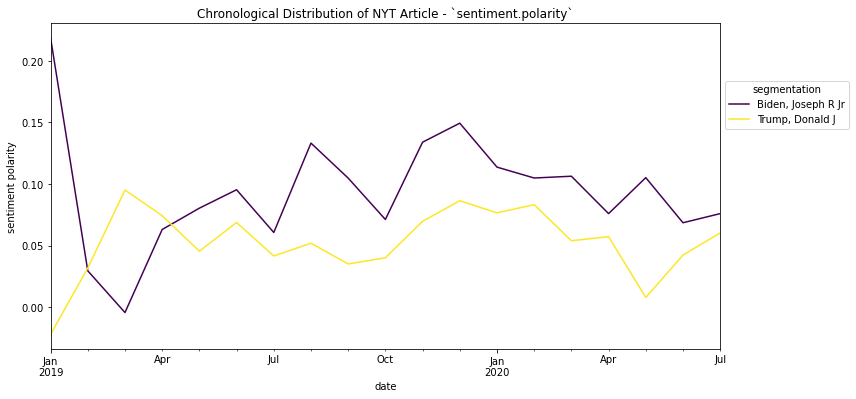

In [392]:
col = 'sentiment.polarity'
tmp = exploded_df[mask].groupby([pd.Grouper(key='pub_date', freq='M'), 'keywords.value'])[col].mean().unstack().sort_index()
column_order = tmp.sum().sort_values(ascending=False).index
tmp = tmp[column_order]
tmp.plot(kind='line', stacked=False, colormap='viridis',
         figsize=(12,6),
         title=f'Chronological Distribution of NYT Article - `{col}`')\
   .set(xlabel='date', ylabel='sentiment polarity')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.75), title='segmentation')

### Conclusion

> We've drawn some interesting insights which must still be validated. A leftish tendency for NYT when it comes to refering to election candidates and also how some subjects are more positive than others (Sports vs. Foreign). A better analysis would be to validate a few data points before publishing any wrong conclusions. Here for simplicity purposes we're leaving it as is!